In [46]:
"""
    openCV에서 사용할 수 있는 crop 함수
    4분할된 이미지 리스트 반환
"""

def image_crop(file, image_width, image_height, cropped_width, cropped_height):
    cropped_images = []
    x = 0
    
    while x < image_width:
        y = 0
        while y < image_height:
            cropped_image = file[x : x + cropped_width, y : y + cropped_height]
            cropped_images.append(cropped_image)
            y += cropped_height
        x += cropped_width
    
    return cropped_images

In [47]:
"""이미지 읽어오기"""

def data_generator(file, image_width, image_height):
    img_bgr = cv2.imread(file , cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img_rgb, (image_width, image_height))

    return img

In [48]:
import random
import cv2

"""이미지 증강 함수"""

def image_augmentation(len_categories, files, index, limit, image_width, image_height):
    random_num = []
    X_array =[]
    y_array = []
    images = []
    data = []
    label = [0 for i in range(len_categories)]
    label[index] = 1
    
#     while len(X_array) <= limit:
    while len(images) < limit:
        try:
            while True:
                i = random.randrange(len(files))
                if i not in random_num or len(random_num) == len(files):
                    break
                
            random_num.append(i)

            file = files[i]        
            
            img = data_generator(file, image_width, image_height)

            images.append(img)
            images.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))  # 시계 방향으로 90도 회전
            images.append(cv2.rotate(img, cv2.ROTATE_180))  # 180도 회전
            images.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)) # 반시계 방향 90도 회전
        
        except Exception as e:
            print(e)
            print(str(i)+" 번째에서 에러 ")
            #             remove(f)
            
    print('파일 길이: ', len(images))
    
    for image in images:
        cropped_images = image_crop(image, image_width, image_height, image_width // 2, image_height // 2)
        for cropped_image in cropped_images:
            data = np.asarray(cropped_image)
            X_array.append(data)
            y_array.append(label)
        
            
    return X_array, y_array

In [49]:
import random

"""이미지 뽑기 함수"""

def image_selector(len_categories, files, index, limit, image_width, image_height):
    random_files = []
    random_num = []
    X_array = []
    y_array = []
    data = []
    label = [0 for i in range(len_categories)]
    label[index] = 1
        
    while len(random_num) < limit:
        rand = random.randrange(len(files))
        if rand not in random_num or len(random_num) == len(files):
            random_num.append(rand)
            random_files.append(files[rand])
    
    #print('랜덤 파일')
    #print(random_files)
    #print('다음')
    
    print('파일 길이: ', len(random_files))
    
    for i, f in enumerate(random_files):
        try:
            img = data_generator(f, image_width, image_height)
            cropped_images = image_crop(img, image_width, image_height, image_width // 2, image_height // 2)
            
            for image in cropped_images:
                data = np.asarray(image)
                X_array.append(data)
                y_array.append(label)

        except Exception as e:
            print(e)
            print(str(i)+" 번째에서 에러 ")
    #             remove(f)
            
    return X_array, y_array

In [50]:
import os, glob

"""하위 폴더 및 파일 탐색"""
    
def is_dir_file(dir_path, dir_list, img_limit, img_limit_list):
    
    folders = os.listdir(dir_path)
    
    for folder in folders:
        path_detail = os.path.join(dir_path, folder)
        
        if os.path.isdir(path_detail):
            new_img_limit = int(img_limit / len(folders))   
            is_dir_file(path_detail, dir_list, new_img_limit, img_limit_list)
        else:    
            print(dir_path + ' img limit : ' + str(img_limit))
            dir_list.append(dir_path)
            img_limit_list.append(img_limit)
            return

In [51]:
"""메인 코드 시작"""

import cv2
import os, glob
from os import remove
import numpy as np

img_dir = './categorical_binary_cnn_by_majority/train'
#categories = os.listdir(img_dir)
categories = ['bill', 'coin', 'general_product', 'graph', 'human', 'lotto_N',
             'lotto_P', 'photoshop', 'non_ad']

sum = 0
ad_index = 0
non_ad_index = 1

size = 280
image_width, image_height = size, size

# file_directory = []
file_list_index = []
img_limit_list = []
X = []
y = []


np_classes = len(categories)    
print(categories)

for i, category in enumerate(categories):
    file_directory = []
    img_dir_detail = os.path.join(img_dir, category)
    
    #if i == ad_index:
     #   img_limit = 1600
    #elif i == non_ad_index:
     #   img_limit = 1600
        
    img_limit = 184
        
    is_dir_file(img_dir_detail, file_directory, img_limit, img_limit_list)
    
    for directory in file_directory:
        file_list_index.append([i, directory])
    
print(file_list_index)

for lst in file_list_index:
    print(lst[0])

count = 0

for index, directory in file_list_index:
    print(directory)
    files = glob.glob(directory + "/*.jpg")
    len_file = len(files)

    img_limit = img_limit_list[count]

    if len_file < img_limit:
        X_temp, y_temp = image_augmentation(np_classes, files, index, img_limit, image_width, image_height)
    else:
        X_temp, y_temp = image_selector(np_classes, files, index, img_limit, image_width, image_height)

    X = X + X_temp
    y = y + y_temp

    len_file = len(X_temp)
    print(directory + '파일 길이 (crop 포함) : ' + str(len_file))
    sum += len_file
    count += 1
    
print('총 파일 길이 (crop 포함) : ' + str(sum))

X = np.array(X)
Y = np.array(y)

print(len(X), len(Y))

"""이미지 크기 인자를 조절하면서 적용"""

['bill', 'coin', 'general_product', 'graph', 'human', 'lotto_N', 'lotto_P', 'photoshop', 'non_ad']
./categorical_binary_cnn_by_majority/train\bill img limit : 184
./categorical_binary_cnn_by_majority/train\coin img limit : 184
./categorical_binary_cnn_by_majority/train\general_product img limit : 184
./categorical_binary_cnn_by_majority/train\graph img limit : 184
./categorical_binary_cnn_by_majority/train\human img limit : 184
./categorical_binary_cnn_by_majority/train\lotto_N img limit : 184
./categorical_binary_cnn_by_majority/train\lotto_P img limit : 184
./categorical_binary_cnn_by_majority/train\photoshop img limit : 184
./categorical_binary_cnn_by_majority/train\non_ad img limit : 184
[[0, './categorical_binary_cnn_by_majority/train\\bill'], [1, './categorical_binary_cnn_by_majority/train\\coin'], [2, './categorical_binary_cnn_by_majority/train\\general_product'], [3, './categorical_binary_cnn_by_majority/train\\graph'], [4, './categorical_binary_cnn_by_majority/train\\human'], 

'이미지 크기 인자를 조절하면서 적용'

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y)
xy = (X_train, X_test, y_train, y_test)

print(X_train.shape)
print(X_train.shape[0])
print(y_train.shape)
print(y_test.shape)

(4962, 140, 140, 3)
4962
(4962, 9)
(1654, 9)


In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [54]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [55]:
# import os
import keras.backend.tensorflow_backend as K

from tensorflow.keras import optimizers

lrate = 0.01
dr = 0.15
#op = optimizers.SGD(lr=lrate, momentum=0.9)
op = 'rmsprop'

with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()

    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(dr))

    model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(dr))
    

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dr))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    #model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dr))
    model.add(BatchNormalization())

    #model.add(Conv2D(128, (3,3), padding="same", activation="relu"))
    #model.add(Conv2D(128, (3,3), padding="same", activation="relu"))
    # model.add(Dropout(0.15))
    #model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(dr))
    model.add(Dense(np_classes, activation="softmax"))

    model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 140, 140, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 70, 70, 32)        0         
_________________________________________________________________
batch_normalization_v1_12 (B (None, 70, 70, 32)        128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 70, 70, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 70, 70, 32)        9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 70, 70, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 35, 32)        0         
__________

In [57]:
batch = 64
epoch = 40

history = model.fit(X_train, y_train, batch_size=batch, epochs=epoch, validation_split=0.15, verbose=1)

Train on 4217 samples, validate on 745 samples
Epoch 1/40
4217/4217 [==============================] - 9s 2ms/sample - loss: 2.4245 - acc: 0.2857 - val_loss: 2.4393 - val_acc: 0.1235
Epoch 2/40
4217/4217 [==============================] - 6s 1ms/sample - loss: 1.7275 - acc: 0.4022 - val_loss: 3.1711 - val_acc: 0.0966
Epoch 3/40
4217/4217 [==============================] - 6s 1ms/sample - loss: 1.5201 - acc: 0.4811 - val_loss: 2.8539 - val_acc: 0.1262
Epoch 4/40
4217/4217 [==============================] - 6s 1ms/sample - loss: 1.3429 - acc: 0.5445 - val_loss: 2.6451 - val_acc: 0.1208
Epoch 5/40
4217/4217 [==============================] - 6s 1ms/sample - loss: 1.1758 - acc: 0.6016 - val_loss: 2.9698 - val_acc: 0.1933
Epoch 6/40
4217/4217 [==============================] - 6s 1ms/sample - loss: 1.0303 - acc: 0.6467 - val_loss: 2.7464 - val_acc: 0.2819
Epoch 7/40
4217/4217 [==============================] - 6s 1ms/sample - loss: 0.8776 - acc: 0.6929 - val_loss: 1.9690 - val_acc: 0.4376
E

In [58]:
"""수정 필요한 부분"""

model.save('./categorical_binary_cnn_by_majority/models/optimizer/categorical_binary_model_saved' + str(op) + '.h5')

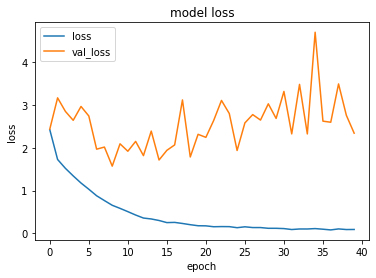

In [59]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

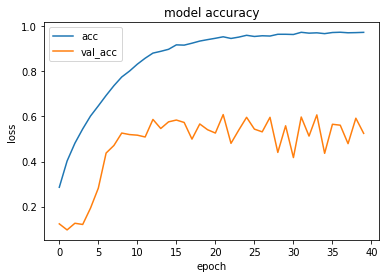

In [60]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'] )
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()